* Set objective function to glucose minimization
* Set upper bounds for biomass: 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 (0.30 is max Rhodotorula growth rate in lab)
* Print all fluxes, find biomass function and NADPH functions (in PPP): 'TALA'=Transaldolase, 'TKT1'=Transketolase, 'TKT2'=Transketolase, 'RPI'=Ribose-5-phosphate isomerase (RKI - vist), 'G6PDH2rp'=Glucose 6-phosphate dehydrogenase (ZWF), 'GND'=Phosphogluconate dehydrogenase (GND), 'PGLp'=6-phosphogluconolactonase

* r_0466 - Glucose 6-phosphate dehydrogenase 
* r_0659 - Isocitrate dehydrogenase (NADP)
* r_0889 - Phosphogluconate dehydrogenase
* r_2140 - Fatty-acyl-CoA synthase (n-C16:0CoA)
* r_2141 - Fatty-acyl-CoA synthase (n-C18:0CoA) 

* Make graphs where specific growth rate is on x-axis and the flux is on y-axis


In [30]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt


In [84]:
# Importing the model
model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")


In [88]:
# Changing the objective function
model.objective = "EX_glc__D_e" 
solution = model.optimize('minimize') # minimize the objective function
solution.objective_value # get the objective value i.e flux of the objective function
# print(model.objective.expression)
# print(model.objective.direction)
# solution

-9999.0

In [44]:
# from cobra.util.solver import linear_reaction_coefficients

# model.reactions.get_by_id("ATPM").upper_bound = 1000
# model.reactions.get_by_id("ATPM").lower_bound = 1.22

# linear_reaction_coefficients(model)
# model.reactions.ATPM.bounds


In [25]:
# Export DataFrames to excel - NB! Will overwrite the pages
# with pd.ExcelWriter("C:\\Users\Maive\\Desktop\\BSc_loputoo\\Simulated_values\\sim_values.xlsx") as excel_writer:
#     PPP_enzymes_fluxes.to_excel(excel_writer, sheet_name='Sheet1', index=False)
#     ATPM_ACITL_fluxes.to_excel(excel_writer, sheet_name='Sheet2', index=False)
#     exchange_fluxes.to_excel(excel_writer, sheet_name='Sheet3', index=False)

In [35]:
# # Changing glucose uptake
# medium = model.medium 
# medium['EX_glc__D_e'] = 4.0 # modifying growth medium to their respective upper import bounds, 4.0 is needed for GR of 0.3
# model.medium = medium

In [36]:
# Get all fluxes
flux_values = solution.fluxes.to_frame(name='Flux') # solution.fluxes gives fluxes for all reactions, to_frame makes it a pandas dataframe
#flux_values 

In [37]:
# Get all fluxes on different GR
GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
flux_values_specific_GR = pd.DataFrame(columns=['GR', *flux_values.index], index=range(len(GR_range))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(GR_range)):
    model.reactions.BIOMASS_RT.bounds = GR_range[i], GR_range[i]
    solution = model.optimize('minimize')
    flux_values_specific_GR.loc[i] = solution.fluxes[['BIOMASS_RT', *flux_values.index]].values
# Example for finding a certain reaction flux: flux_values_specific_GR['EX_o2_e']
# flux_values_specific_GR

In [38]:
def get_fluxes_on_specific_GR(model, GR_range, enzymes, minimize = True):
    fluxes = pd.DataFrame(columns=['GR', *enzymes], index=range(len(GR_range)))
    for i in range(len(GR_range)):
        model.reactions.BIOMASS_RT.bounds = GR_range[i], GR_range[i]
        solution = model.optimize('minimize' if minimize else 'maximize')        
        fluxes.loc[i] = solution.fluxes[['BIOMASS_RT', *enzymes]].values
    return fluxes

In [90]:
# Fluxes for ATPM and ACITL
GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
enzymes = ['ACITL']
ATPM_ACITL_fluxes = get_fluxes_on_specific_GR(model, GR_range, enzymes)
ATPM_ACITL_fluxes


,GR,ATPM,ACITL
0,0.05,1.22,0.0
1,0.1,1.22,0.0
2,0.15,1.22,0.0
3,0.2,1.22,0.0
4,0.25,1.22,0.0
5,0.3,1.22,0.0


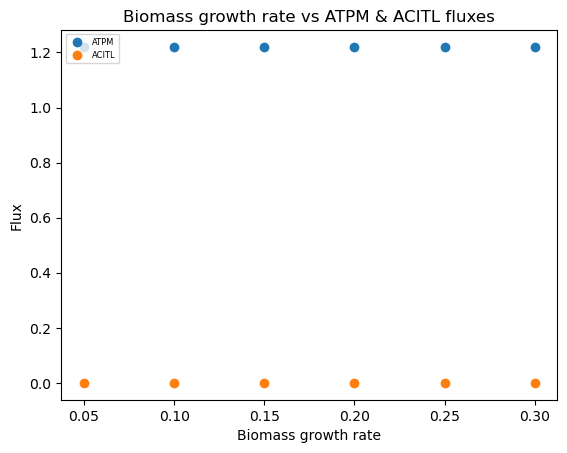

In [17]:
plt.plot(GR_range, np.abs(ATPM_ACITL_fluxes[['ATPM', 'ACITL']]), 'o', label=['ATPM', 'ACITL'])
plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.title("Biomass growth rate vs ATPM & ACITL fluxes")
plt.legend(fontsize=6, loc='upper left')
plt.show()

In [99]:
# Get fluxes for PPP enzymes
# add phosphoketolase 'XPK', pyruvate decarboxylase 'PYRDC', pyruvate dehydrogenase 'PDHm'

GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
enzymes = ['TALA', 'TKT1', 'TKT2', 'RPI', 'G6PDH2rp', 'GND','PGLp','XPK','PYRDC','PDHm']
PPP_enzymes_fluxes = get_fluxes_on_specific_GR(model, GR_range, enzymes)
# PPP_enzymes_fluxes


In [100]:
# Add the values together that are the same - oxpp> all these four are the same, get their absolute value
# oxpp
PPP_enzymes_fluxes['oxpp'] = (PPP_enzymes_fluxes.G6PDH2rp + PPP_enzymes_fluxes.PGLp + PPP_enzymes_fluxes.GND + PPP_enzymes_fluxes.RPI)/4
PPP_enzymes_fluxes

,GR,TALA,TKT1,TKT2,RPI,G6PDH2rp,GND,PGLp,XPK,PYRDC,PDHm,oxpp
0,0.05,0.0,-7.170386,14.247339,7.077127,0.0,0.0,0.0,0.0,0.0,0.0,1.769282
1,0.1,0.0,-13.730772,27.274678,13.544255,0.0,0.0,0.0,0.0,0.0,0.0,3.386064
2,0.15,0.0,-20.291157,40.302017,20.011382,0.0,0.0,0.0,0.0,0.0,0.0,5.002845
3,0.2,0.0,-26.851543,53.329356,26.478509,0.0,0.0,0.0,0.0,0.0,0.0,6.619627
4,0.25,0.0,-33.411929,66.356695,32.945637,0.0,0.0,0.0,0.0,0.0,0.0,8.236409
5,0.3,0.0,-39.972315,79.384034,39.412764,0.0,0.0,0.0,0.0,0.0,0.0,9.853191


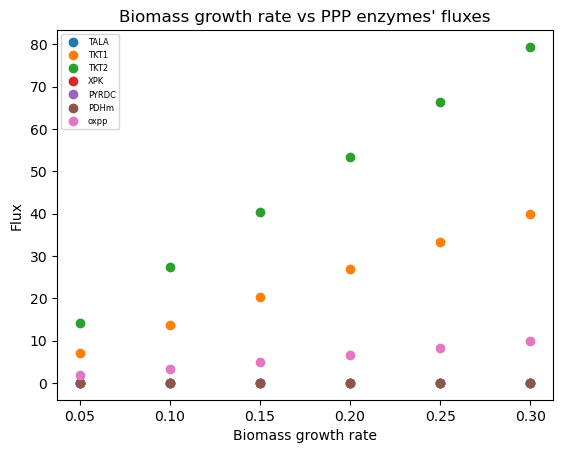

In [101]:
# Plot the PPP enzymes fluxes

plt.plot(PPP_enzymes_fluxes['GR'], np.abs(PPP_enzymes_fluxes[['TALA', 'TKT1',	'TKT2',	'XPK','PYRDC','PDHm', 'oxpp']]), 'o', label=['TALA', 'TKT1', 'TKT2','XPK','PYRDC','PDHm', 'oxpp'])
plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.title("Biomass growth rate vs PPP enzymes' fluxes")
plt.legend(fontsize=6, loc='upper left')
plt.show()

# exchange_fluxes_all = model.summary().to_frame()
# exchange_fluxes_all = exchange_fluxes_all[abs(exchange_fluxes_all['flux']) != 0.01]
# exchange_fluxes_all = exchange_fluxes_all[['metabolite', 'flux']]
# # exchange_fluxes_all

In [102]:
# #Change glucose bounds
# model.reactions.get_by_id("BIOMASS_RT").upper_bound = 0.3
# model.reactions.get_by_id("BIOMASS_RT").lower_bound = 0.3
# # Make sure no amino acid uptake, constrain those reactions
# #model.reactions.get_by_id("EX_glc__D_e")
# # model.reactions.get_by_id("EX_co2_e").upper_bound = 9999
# model.summary()


In [72]:
# model.reactions.BIOMASS_RT.bounds = GR_range[1], GR_range[1]
# summary005 = model.summary() #.to_frame() #exchange fluxes
# # summary005 = summary005[abs(summary005['flux']) != 0.0]
# #summary005


In [145]:
# # Getting exchange fluxes
# GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
# # def get_exchange_fluxes(model, GR_range, minimize = True ):
# for i in range(len(GR_range)):
#     model.reactions.BIOMASS_RT.bounds = GR_range[i], GR_range[i]
#     solution = model.optimize('minimize')       #('minimize' if minimize else 'maximize') # minimize the objective function   
#     if i == 0:
#         summary005 = model.summary().to_frame()
#         summary005 = summary005[abs(summary005['flux']) != 0.0]
#         summary005 = summary005[['metabolite', 'flux']]

    # elif i == 1:
    #     summary010 = model.summary().to_frame()
    #     summary010 = summary010[abs(summary010['flux']) != 0.0]
    #     summary010 = summary010[['metabolite', 'flux']]

    # elif i == 2:
    #     summary015 = model.summary().to_frame()
    #     summary015 = summary015[abs(summary015['flux']) != 0.0]
    #     summary010 = summary010[['metabolite', 'flux']]


    # elif i == 3:
    #     summary020 = model.summary().to_frame()
    #     summary020 = summary020[abs(summary020['flux']) != 0.0]
    #     summary020 = summary020[['metabolite', 'flux']]


    # elif i == 4:
    #     summary025 = model.summary().to_frame()
    #     summary025 = summary025[abs(summary025['flux']) != 0.0]
    #     summary025 = summary025[['metabolite', 'flux']]


    # elif i == 5:
    #     summary030 = model.summary().to_frame()
    #     summary030 = summary030[abs(summary030['flux']) != 0.0]
    #     summary030 = summary030[['metabolite', 'flux']]
        




In [190]:

# Make a pd dataframe with all exchange fluxes that are not zero, then make a pivot table with metabolites fluxes on specific growth rate
GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

model.reactions.BIOMASS_RT.bounds = GR_range[0], GR_range[0]
solution = model.optimize('minimize')
exchange_fluxes_all = model.summary().to_frame()
exchange_fluxes_all['GR'] = GR_range[0]


for i in range(1, len(GR_range)):
    model.reactions.BIOMASS_RT.bounds = GR_range[i], GR_range[i]
    solution = model.optimize('minimize')
    model_summary = model.summary().to_frame()
    model_summary['GR'] = GR_range[i]
    exchange_fluxes_all = pd.concat([exchange_fluxes_all, model_summary], axis=0)  
    
exchange_fluxes_all = exchange_fluxes_all[(exchange_fluxes_all['flux']) != 0.0]
exchange_fluxes_all['flux'] = abs(exchange_fluxes_all['flux'])

# Get specific metabolites with their fluxes
exchange_fluxes_table = pd.pivot_table(exchange_fluxes_all[exchange_fluxes_all.metabolite.isin(["co2_e", "ca2_e", 'cu2_e', 'fe2_e', 'fe3_e', 'glc__D_e'])], 
                                       values='flux', index=['GR'], columns=['metabolite'])


exchange_fluxes_table


metabolite,ca2_e,co2_e,cu2_e,fe2_e,fe3_e,glc__D_e
GR,,,,,,
0.05,0.000042,1.803280,0.000026,0.000214,0.000308,0.691224
0.10,0.000083,3.423804,0.000053,0.000428,0.000617,1.351989
0.15,0.000125,5.044459,0.000079,0.000643,0.000925,2.012776
0.20,0.000166,6.665114,0.000105,0.000857,0.001234,2.673563
0.25,0.000208,8.285770,0.000131,0.001071,0.001542,3.334350
0.30,0.000250,9.906425,0.000157,0.001285,0.001851,3.995137


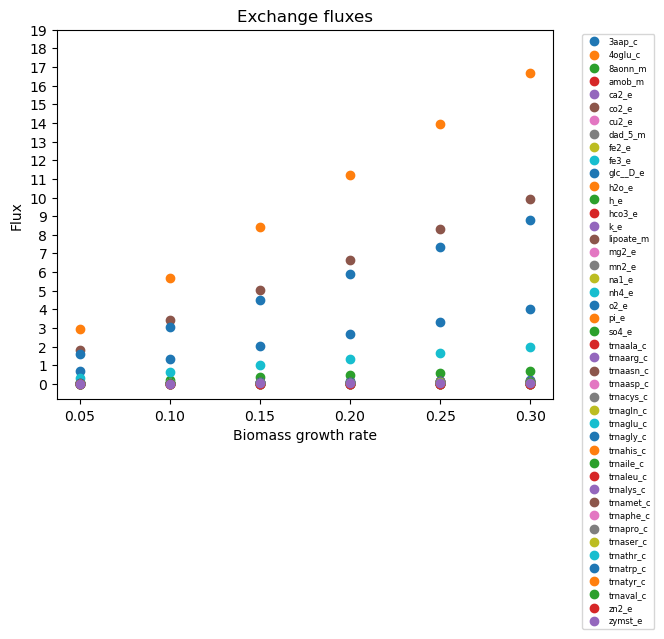

In [164]:
# Make plots for exchange reactions

plt.plot(GR_range, exchange_fluxes_table[exchange_fluxes_table.columns], 'o', label = exchange_fluxes_table.columns)

plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.title("Exchange fluxes")
plt.legend(fontsize=6, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.yticks(range(0, 20, 1))
plt.show()



In [5]:

# # Make metabolic map using escher
# import escher
# from escher import Builder
# from time import sleep

In [ ]:
# builder = Builder()


In [7]:
from pathlib import Path
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model
import logging
save_json_model(model, "C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\edited_model.json")